# CS4035 - Cyber Data Analytics
## Lab 1 - Fraud data

## Group Number : 25

## Student 1 
### Name : Aditya Kunar
### ID : 5074274

## Student 2
### Name : Anwesh Marwade
### ID : 5052068

### Readme - Running our code is pretty straightforward. The comments will explicitely state what to do further down wherever human input is required. For running our code, you'll need sklearn, matplotlib, seaborn, pandas,numpy, random and re which are commonly used libraries which you will probably have installed. Lastly, the only data you'll need is what was initially provided to us all in brightspace. 


### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import re
from random import randint
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import ComplementNB
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.pipeline import make_pipeline

### Reading in the Data (The one provided to us in brightspace.)

In [2]:
data = "data_for_student_case.csv" #Provide the path to the data here.
df_OG = pd.read_csv(data)

### Preprocessing 

In [30]:
# Apply currency conversion so that the amounts are standardized
def conv(row):
    currency_dict = {0: 0.86248, 1: 1.5911, 2: 21.2829, 3: 1.6805, 4: 10.635}
    return row['amount'] / (currency_dict[row['currencycode']]*100)

def preprocess(df):
    # Here we simply remove the refuse class from our dataframe.
    df1 = df.copy(deep=True)
    df1 = df1.loc[~(df1['simple_journal'] == 'Refused')] #removing the unknown class.
    df1.loc[df1['simple_journal'] == 'Chargeback', 'simple_journal'] = 1 #fraud
    df1.loc[df1['simple_journal'] == 'Settled', 'simple_journal'] = 0 #Normal
    
    #Dealing with na values by filling them with default values. 
    df1.loc[df1['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
    df1.loc[df1['issuercountrycode'].isna(),'issuercountrycode'] = 'ZZ'
    df1.loc[df1['shoppercountrycode'].isna(),'shoppercountrycode'] = 'ZZ'
    df1.loc[df1['mail_id'].str.contains('na',case=False),'mail_id'] = 'email99999'
    
    #3-6 is made to be 3 for cvcresponsecode variable.
    df1.loc[df1['cvcresponsecode'] > 2,'cvcresponsecode'] = 3
    
    #Encoding the categorical variables.
    bin_enc = LabelEncoder()
    bin_enc.fit(df1['bin'].unique())
    df1['bin'] = bin_enc.transform(df1.bin)

    card_enc = LabelEncoder()
    card_enc.fit(df1['card_id'])
    df1['card_id'] = card_enc.transform(df1.card_id)

    ip_enc = LabelEncoder()
    ip_enc.fit(df1['ip_id'])
    df1['ip_id'] = ip_enc.transform(df1.ip_id)

    unique_issuer_cc = df1['issuercountrycode'].unique()
    unique_shopper_cc = df1['shoppercountrycode'].unique()
    both = np.append(unique_issuer_cc, unique_shopper_cc)
    df_countrycodes = pd.DataFrame(both)
    unique_codes = df_countrycodes[0].unique()
    enc = LabelEncoder()
    enc.fit(unique_codes)
    df1['issuercountrycode'] = enc.transform(df1.issuercountrycode)
    df1['shoppercountrycode'] = enc.transform(df1.shoppercountrycode)
    
    enc = LabelEncoder()
    enc.fit(df1['txvariantcode'])
    df1['txvariantcode'] = enc.transform(df1.txvariantcode)

    enc = LabelEncoder()
    enc.fit(df1['currencycode'])
    df1['currencycode'] = enc.transform(df1.currencycode)

    enc = LabelEncoder()
    enc.fit(df1['shopperinteraction'])
    df1['shopperinteraction'] = enc.transform(df1.shopperinteraction)

    enc = LabelEncoder()
    enc.fit(df1['accountcode'])
    df1['accountcode'] = enc.transform(df1.accountcode)

    enc = LabelEncoder()
    enc.fit(df1['cardverificationcodesupplied'])
    df1['cardverificationcodesupplied'] = enc.transform(df1.cardverificationcodesupplied)
    
    enc = LabelEncoder()
    enc.fit(df1['mail_id'])
    df1['mail_id'] = enc.transform(df1.mail_id)

    
    df1['countries_equal'] = (df1['shoppercountrycode'] == df1['issuercountrycode'])
    df1.loc[df1['countries_equal'] == False,'countries_equal'] = 0
    df1.loc[df1['countries_equal'] == True,'countries_equal'] = 1

    #Converting creation and booking date to datestamps.
    df1['creationdate'] = pd.to_datetime(df1['creationdate'])
    df1['bookingdate'] = pd.to_datetime(df1['bookingdate'])
    
    #Obtaining the day of week and hour of transactions using date timestamps. 
    df1['date'] = df1['creationdate'].dt.date 
    df1['day_of_week'] = df1['creationdate'].dt.dayofweek
    df1['hour'] = df1['creationdate'].dt.hour
    
    #converting creation date to unix_timestap.
    dates= df1["creationdate"]
    dates=pd.DatetimeIndex(dates)
    dates=dates.astype(np.int64) // 10**9
    df1['creationdate_Unix']=dates
    
    #Standardizing amount to a single currency.
    df1['amount_eur'] = df1.apply(lambda x: conv(x), axis=1)
    df1 = df1.loc[~((df1['simple_journal'] == 0)&(df1['amount_eur']>320))]
    return df1
# Pre-processing the dataframe.
df1=preprocess(df_OG)

### Transaction Class distributions.

In [31]:
print("Number of total data points = " + str(len(df1.index)))
print("Number of fradulent transactions = " + str(len(df1.loc[df1['simple_journal'] == 1])))
print("Number of valid transactions = " + str(len(df1.loc[df1['simple_journal'] == 0])))  

Number of total data points = 235503
Number of fradulent transactions = 345
Number of valid transactions = 235158


## 1. Visualization task 

#### I) Account Code and Number of Fraud

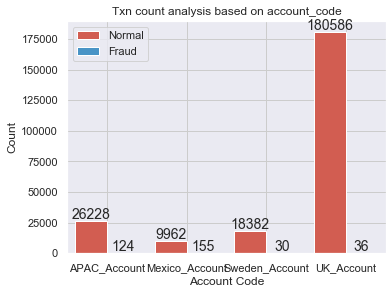

In [32]:
sns.set(rc={'figure.figsize':(5.7,4.27)})
flatui = ["#e74c3c","#3498db", "#2ecc71"]
ax = sns.countplot(x="accountcode", hue="simple_journal", data=df1, palette=flatui)
ax.set_title('Txn count analysis based on account_code')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel('Account Code')
ax.set(xticklabels=["APAC_Account","Mexico_Account","Sweden_Account","UK_Account"])
ax.legend(["Normal","Fraud"]) 
max_height = 0


for p in ax.patches:
    if p.get_height() > max_height:
        max_height = p.get_height()
    
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
            height + 0.01*max_height,'{:1d}'.format(height),
            ha="center",size=14)

#### Description-Based on this barchart, we see that there is an uneven distribution of fraud and non fraud cases from the different accounts in our dataset. We also observe that the majority of fraud cases originate from the Mexico account even though the majority transactions have occured from the UK account. 

#### II) Amount in Euros Distribution for Fraud vs Normal

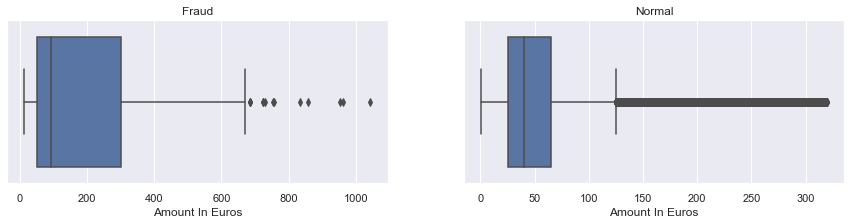

In [33]:
df_f = df1.loc[df1.simple_journal==1]
df_nf = df1.loc[df1.simple_journal==0]
nf_amt=df_nf.amount_eur.values
f_amt=df_f.amount_eur.values 
f, (ax1, ax2) = plt.subplots(1,2,figsize =(15, 3))
sns.boxplot(f_amt,ax=ax1)
ax1.set_title('Fraud')
sns.boxplot(nf_amt,ax=ax2)
ax2.set_title('Normal')
ax2.set_xlabel("Amount In Euros")
ax1.set_xlabel("Amount In Euros")
plt.show()

#### Description- We observe from the boxplots that fruadulent transactions have a wider interquartile range than non fraudulent cases with respect to amount in euros spent per transaction. And so, the distribution of amount in euros for fraud generally seems to be higher than non fraud cases as indicated by the two medians as well. But we need to keep in mind that there are many outliers for non-fraud transactions. 

#### III) Temporal relationship between Currency_code and number of fraudulent transactions

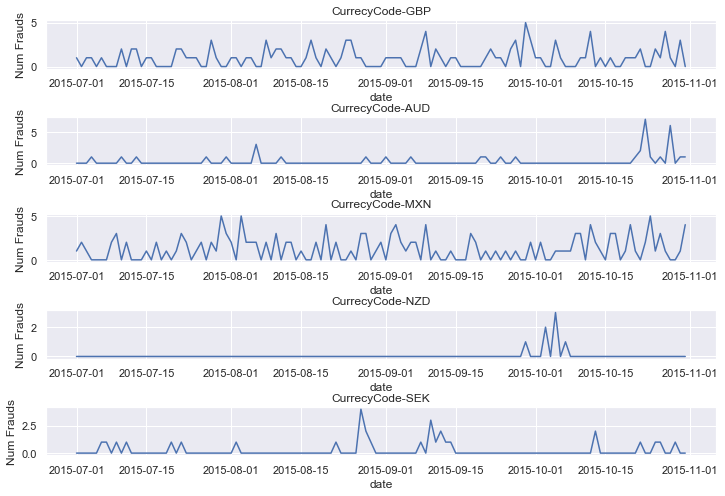

In [34]:
df_GBP=df1.loc[df1["currencycode"]==0]
df_AUD=df1.loc[df1["currencycode"]==1]
df_MXN=df1.loc[df1["currencycode"]==2]
df_NZD=df1.loc[df1["currencycode"]==3]
df_SEK=df1.loc[df1["currencycode"]==4]

df_GBP = df_GBP[['date','simple_journal']].groupby(['date']).sum()
df_AUD = df_AUD[['date','simple_journal']].groupby(['date']).sum()
df_MXN = df_MXN[['date','simple_journal']].groupby(['date']).sum()
df_NZD = df_NZD[['date','simple_journal']].groupby(['date']).sum()
df_SEK = df_SEK[['date','simple_journal']].groupby(['date']).sum()

#len(df4.loc[df4['simple_journal'] > 0])

f, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize =(12, 8))
sns.lineplot(x=df_GBP.index,y=df_GBP['simple_journal'],ax=ax1)
ax1.set(ylabel = "Num Frauds")
ax1.set_title("CurrecyCode-GBP")
sns.lineplot(x=df_AUD.index,y=df_AUD['simple_journal'],ax=ax2)
ax2.set(ylabel = "Num Frauds")
ax2.set_title("CurrecyCode-AUD")
sns.lineplot(x=df_MXN.index,y=df_MXN['simple_journal'],ax=ax3)
ax3.set(ylabel = "Num Frauds")
ax3.set_title("CurrecyCode-MXN")
sns.lineplot(x=df_NZD.index,y=df_NZD['simple_journal'],ax=ax4)
ax4.set(ylabel = "Num Frauds")
ax4.set_title("CurrecyCode-NZD")
sns.lineplot(x=df_SEK.index,y=df_SEK['simple_journal'],ax=ax5)
ax5.set(ylabel = "Num Frauds")
ax5.set_title("CurrecyCode-SEK")
plt.subplots_adjust(hspace=1)
plt.show()

#### Description- Based on the lineplots above, first we see that fraudulent transactions happen more frequently for the GBP and MXN currency codes. Secondly, we do not see any significant overlaps between dates on which most currency codes show high number of fraud cases suggesting that date is not a common denominator when it comes to fraudulent transactions.

#### IV) Difference in mean amount in euros with respect to cvcresponse code for fraud and non fraud cases.

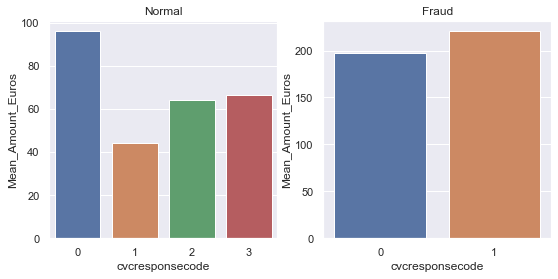

In [35]:
dff= df1.loc[df1["simple_journal"]==1]
df_nf=df1.loc[df1["simple_journal"]==0]
df5 = dff[['cvcresponsecode','amount_eur']].groupby(['cvcresponsecode']).mean()
df6 = df_nf[['cvcresponsecode','amount_eur']].groupby(['cvcresponsecode']).mean()
f, (ax1,ax2) = plt.subplots(1,2,figsize =(9, 4))
sns.barplot(x=df5.index,y=df5['amount_eur'],ax=ax2)
ax2.set(ylabel = "Mean_Amount_Euros")
ax2.set_title("Fraud")
sns.barplot(x=df6.index,y=df6['amount_eur'],ax=ax1)
ax1.set(ylabel = "Mean_Amount_Euros")
ax1.set_title("Normal")

plt.show()

#### Description- Based on the barcharts shown above we can see that for normal transactions, the mean amount in euros is higher for cvcresponsecode 0 which corresponds to unknown, however for fraud cases, the mean amount in euros is higher for cvcresponsecode 1 which corresponds to a match found. This suggests that fraudsters are good at disguising their transactions as real ones. We also note that the mean amount in terms of euros is actually also much higher for fraud cases than non fraud transactions. This can be explained with respect to the boxplots we saw previously.

#### V) Percentage fraud cases associated with cvcresponsecode for local vs international transactions

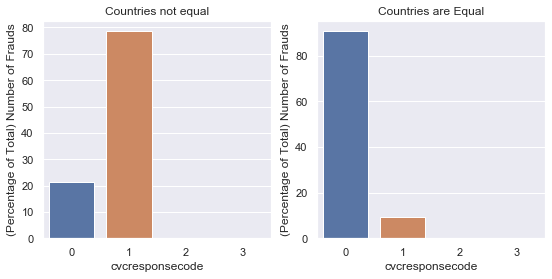

In [36]:
dff= df1.loc[df1["countries_equal"]==1]
df_nf=df1.loc[df1["countries_equal"]==0]
df5 = dff[['cvcresponsecode','simple_journal']].groupby(['cvcresponsecode']).sum()
total=df5["simple_journal"].sum()
df5["simple_journal"]=(df5["simple_journal"]/total)*100
df6 = df_nf[['cvcresponsecode','simple_journal']].groupby(['cvcresponsecode']).sum()
total=df6["simple_journal"].sum()
df6["simple_journal"]=(df6["simple_journal"]/total)*100
f, (ax1,ax2) = plt.subplots(1,2,figsize =(9, 4))
sns.barplot(x=df5.index,y=df5['simple_journal'],ax=ax2)
ax2.set(ylabel = "(Percentage of Total) Number of Frauds")
ax2.set_title("Countries are Equal")
sns.barplot(x=df6.index,y=df6['simple_journal'],ax=ax1)
ax1.set(ylabel = "(Percentage of Total) Number of Frauds")
ax1.set_title("Countries not equal")
plt.show()

#### Description- Based on the barcharts shown above we can see that for international transactions the percentage of fraud cases with a cvcresponsecode of 1 is higher whereas for local transactions, the cvcresponsecode with a value of 0 is the majority. 

#### VI) Issuercountrycode and mean amount in euros for fraud vs normal transactions.

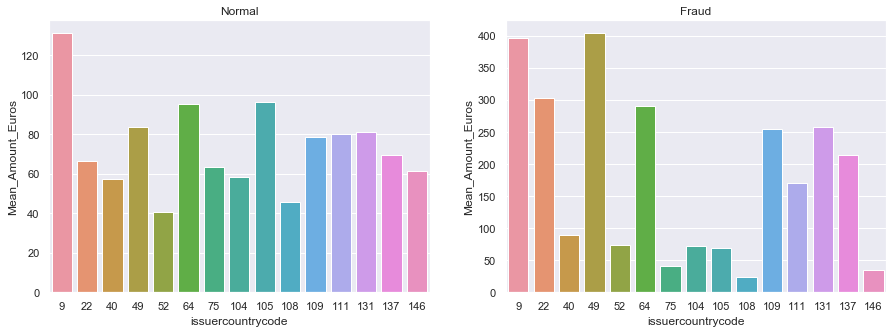

In [37]:
dff= df1.loc[df1["simple_journal"]==1]
df_nf=df1.loc[(df1["simple_journal"]==0) & (df1["issuercountrycode"].isin([9,22,40,49,52,64,75,104,105,108,109,111,131,137,146]))]
df5 = dff[['issuercountrycode','amount_eur']].groupby(['issuercountrycode']).mean()
df6 = df_nf[['issuercountrycode','amount_eur']].groupby(['issuercountrycode']).mean()
f, (ax1,ax2) = plt.subplots(1,2,figsize =(15, 5))
sns.barplot(x=df5.index,y=df5['amount_eur'],ax=ax2)
ax2.set(ylabel = "Mean_Amount_Euros")
ax2.set_title("Fraud")
sns.barplot(x=df6.index,y=df6['amount_eur'],ax=ax1)
ax1.set(ylabel = "Mean_Amount_Euros")
ax1.set_title("Normal")
plt.show()

#### Description- Based on the barchart, we first see that fraudulent transactions actually have a higher mean amount in most countries than normal transactions. We also see that the distribution of spending for different countries is not homogenous with the highest mean amount in euros for fraud occuring in issuer_country_codes 49 and 9.

#### VII) TxVariant and Mean Amount in Euros for normal and fraud cases

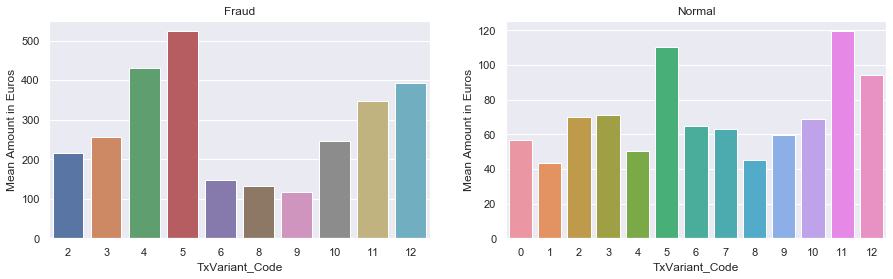

In [38]:
df2 = df1.loc[df1["simple_journal"]==1][['txvariantcode','amount_eur']].groupby(['txvariantcode']).mean()
f, (ax1,ax2) = plt.subplots(1,2,figsize =(15, 4))
sns.barplot(x=df2.index,y=df2['amount_eur'],ax=ax1)
ax1.set(ylabel = "Mean Amount in Euros")
ax1.set_xlabel('TxVariant_Code')
ax1.set_title("Fraud")
df2 = df1.loc[df1["simple_journal"]==0][['txvariantcode','amount_eur']].groupby(['txvariantcode']).mean()
sns.set(style="whitegrid")
sns.barplot(x=df2.index,y=df2['amount_eur'],ax=ax2)
ax2.set(ylabel = "Mean Amount in Euros")
ax2.set_xlabel('TxVariant_Code')
ax2.set_title("Normal")
plt.show()

#### Description- The above barchart showcases the differences in mean amount in euros for the different txvariant_codes. We similarly see a common trend that mean amount in euros is usually higher for fraudulent transactions. We also see that TxVariant_codes 5 and 4 have the highest mean amount in euros with respect to fraud. 

## 3. Privacy task – 1 A4 – Individual

In [39]:
#What the data looks like without swapping
df1.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,...,accountcode,mail_id,ip_id,card_id,countries_equal,date,day_of_week,hour,creationdate_Unix,amount_eur
0,1,2015-11-09 14:26:51,104,2,1998,64800.0,2,104,1,1,...,1,187702,7386,73358,1,2015-07-01,2,23,1435791791,30.446979
1,2,2015-11-09 14:27:38,104,2,2364,44900.0,2,104,1,1,...,1,834,194109,44739,1,2015-07-02,3,4,1435812655,21.096749
2,3,2015-11-23 16:34:16,104,2,1965,149900.0,2,104,1,1,...,1,119287,189655,122802,1,2015-07-02,3,14,1435847428,70.432131
3,4,2015-11-23 16:34:51,104,2,2374,109900.0,2,104,1,1,...,1,173561,8254,70712,1,2015-07-03,4,7,1435910017,51.637700
4,5,2015-11-09 14:26:08,104,6,1301,89900.0,2,104,1,1,...,1,70647,196247,208481,1,2015-07-08,2,18,1436380535,42.240484


In [40]:
#These columns are not relevant to the classifier and can therefore be ignored.
df_notswapped = df1.drop(columns=['txid','creationdate','bookingdate','amount','date'])

In [41]:
# Rank swapping function
def rank_swap(perc,column,df):
    #Percentage of total rows for which we can safely switch two ranked items in a column.
    p = perc
    #The column for which we wish to do the rank swapping.
    c = column
    #Sort the dataframe based on the column
    sortbycol = df.sort_values(c)
    #Extract the index of the dataframe.
    sortedbycolindex=sortbycol.index.to_list()
    #Calculate the interval within which swaps of ranked values are allowed.
    interval = int(len(df.index)*(p/100))
    #This set checks if values have been swapped and skips those values.
    value_list=set()
    for i in range(len(sortedbycolindex)):
        if i in value_list:
            continue
        #Just sampling a random value and doing it until the value agrees with the interval.    
        value = randint(0,len(sortedbycolindex)-1)
        while(abs(i-value)>interval):
            value = randint(0,len(sortedbycolindex)-1)
        #Adding swapped value indexes to the value_list set.
        value_list.add(value)
        #Doing the actual swap. 
        sortedbycolindex[i], sortedbycolindex[value] = sortedbycolindex[value], sortedbycolindex[i]
    
    #Reordering a new dataframe based on index.
    newdf=df.reindex(sortedbycolindex)  
    #Getting the values in the order we need.
    v=newdf[c]
    #Assigning the values of that order in the original dataframe
    df[c]=v.values
    #Returning the dataframe and exiting the function.
    return df     

In [42]:
#Only rankswapping those with ordinal component.
df_swapped=df1.drop(columns=['txid','creationdate','bookingdate','amount','date'])
df_swapped = rank_swap(10,"amount_eur",df_swapped)
df_swapped = rank_swap(10,"creationdate_Unix",df_swapped)
df_swapped = rank_swap(10,"day_of_week",df_swapped)
df_swapped = rank_swap(10,"hour",df_swapped)

In [43]:
# Having a look at non-swapped data.
df_notswapped

,issuercountrycode,txvariantcode,bin,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,countries_equal,day_of_week,hour,creationdate_Unix,amount_eur
0,104,2,1998,2,104,1,1,1,0,1,187702,7386,73358,1,2,23,1435791791,30.446979
1,104,2,2364,2,104,1,1,1,0,1,834,194109,44739,1,3,4,1435812655,21.096749
2,104,2,1965,2,104,1,1,1,0,1,119287,189655,122802,1,3,14,1435847428,70.432131
3,104,2,2374,2,104,1,1,1,0,1,173561,8254,70712,1,4,7,1435910017,51.637700
4,104,6,1301,2,104,1,1,1,0,1,70647,196247,208481,1,2,18,1436380535,42.240484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290377,131,8,784,4,131,1,0,1,1,2,23852,16764,196325,1,5,23,1446333718,45.228021
290378,131,3,2508,4,131,1,0,1,1,2,106775,67997,27390,1,5,23,1446334284,183.356841
290379,131,8,784,4,131,1,0,1,1,2,152970,87084,36581,1,5,23,1446334900,49.365303
290380,131,3,2508,4,131,1,0,1,1,2,206916,66888,36060,1,5,23,1446335407,82.463564


In [44]:
# Looking at the swapped data.
df_swapped

,issuercountrycode,txvariantcode,bin,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,countries_equal,day_of_week,hour,creationdate_Unix,amount_eur
0,104,2,1998,2,104,1,1,1,0,1,187702,7386,73358,1,0,0,1436611092,15.680975
1,104,2,2364,2,104,1,1,1,0,1,834,194109,44739,1,0,1,1436614106,7.070580
2,104,2,1965,2,104,1,1,1,0,1,119287,189655,122802,1,0,1,1436305881,7.000926
3,104,2,2374,2,104,1,1,1,0,1,173561,8254,70712,1,0,0,1436479193,7.479103
4,104,6,1301,2,104,1,1,1,0,1,70647,196247,208481,1,0,1,1436094472,7.667651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290377,131,8,784,4,131,1,0,1,1,2,23852,16764,196325,1,6,23,1445901812,112.469361
290378,131,3,2508,4,131,1,0,1,1,2,106775,67997,27390,1,6,23,1445196731,145.039962
290379,131,8,784,4,131,1,0,1,1,2,152970,87084,36581,1,6,21,1445601427,187.945447
290380,131,3,2508,4,131,1,0,1,1,2,206916,66888,36060,1,6,23,1445157548,167.540117


In [56]:
#swapping every column.
df_allswapped=df1.drop(columns=['txid','creationdate','bookingdate','amount','date'])
for i in df_notswapped.columns:
    df_allswapped=rank_swap(20,i,df_allswapped)

In [57]:
df_allswapped

,issuercountrycode,txvariantcode,bin,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,countries_equal,day_of_week,hour,creationdate_Unix,amount_eur
0,52,2,784,0,9,1,0,0,0,0,6504,31798,39936,0,0,9,1437404163,15.712400
1,52,2,40,0,52,1,0,0,0,0,20416,30477,13882,0,1,0,1437747688,11.671171
2,9,2,698,0,52,1,0,1,0,1,20621,34834,25699,1,0,8,1435890173,17.440764
3,9,2,692,1,52,1,0,0,0,2,6762,25259,36862,1,1,0,1435963359,16.309471
4,9,2,797,1,52,0,0,0,0,0,5025,35665,26000,1,0,6,1435868232,9.427440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290377,104,8,2537,1,109,1,0,1,1,3,202722,201290,187863,1,6,22,1444258967,128.118913
290378,131,8,1738,4,111,1,0,1,1,3,187244,199328,202782,1,5,22,1444389469,182.323068
290379,52,10,2444,4,131,1,0,1,1,3,132121,119959,208529,1,6,22,1444494573,113.061589
290380,146,8,2219,2,111,1,0,1,1,3,183650,187419,200143,1,4,22,1442328678,163.610719


In [58]:
# Creating the data and the labels for training.
X1 = df_swapped.drop(columns="simple_journal")
y1 = df_swapped["simple_journal"]
X2 = df_allswapped.drop(columns="simple_journal")
y2 = df_allswapped["simple_journal"]
X3 = df_notswapped.drop(columns="simple_journal")
y3 = df_notswapped["simple_journal"]

In [59]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y1,stratify=y1,test_size=0.33)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2,stratify=y2,test_size=0.33)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3,y3,stratify=y3,test_size=0.33)

In [60]:
#Scaling the data before we feed it into the classifier. 
scaler = MinMaxScaler()
scaler.fit(X1_train)
X1_train = scaler.transform(X1_train)
X1_test = scaler.transform(X1_test)
scaler.fit(X2_train)
X2_train = scaler.transform(X2_train)
X2_test = scaler.transform(X2_test)
scaler.fit(X3_train)
X3_train = scaler.transform(X3_train)
X3_test = scaler.transform(X3_test)

In [61]:
#Number of samples and the number of fraud cases in train and test. 
(X3_train.shape,y3_train.sum()),(X3_test.shape,y3_test.sum())

(((157787, 17), 231), ((77716, 17), 114))

In [62]:
#subsampling the training datasets keeping a 20% fraud and 80% non fraud class distribution.
posindex=[]
for i in enumerate(y1_train):
    if i[1]==1:
        posindex.append(i[0])
fullindex=list(range(0,len(y1_train)))
sampleindex= list(set(fullindex)-set(posindex))
randomlist = list(set(random.sample(range(0, len(sampleindex)),924)))
randomlist = list(np.array(sampleindex)[randomlist])
randomlist.extend(posindex)
random.shuffle(randomlist)
X1_train=(X1_train[randomlist])
y1_train=np.array(y1_train)
y1_train=y1_train[randomlist].ravel()
posindex=[]
for i in enumerate(y2_train):
    if i[1]==1:
        posindex.append(i[0])
fullindex=list(range(0,len(y2_train)))
sampleindex= list(set(fullindex)-set(posindex))
randomlist = list(set(random.sample(range(0, len(sampleindex)),924)))
randomlist = list(np.array(sampleindex)[randomlist])
randomlist.extend(posindex)
random.shuffle(randomlist)
X2_train=(X2_train[randomlist])
y2_train=np.array(y2_train)
y2_train=y2_train[randomlist].ravel()
posindex=[]
for i in enumerate(y3_train):
    if i[1]==1:
        posindex.append(i[0])
fullindex=list(range(0,len(y3_train)))
sampleindex= list(set(fullindex)-set(posindex))
randomlist = list(set(random.sample(range(0, len(sampleindex)),924)))
randomlist = list(np.array(sampleindex)[randomlist])
randomlist.extend(posindex)
random.shuffle(randomlist)
X3_train=(X3_train[randomlist])
y3_train=np.array(y3_train)
y3_train=y3_train[randomlist].ravel()

In [63]:
#Number of samples and the number of fraud cases in train and test after subsampling. 
(X3_train.shape,y3_train.sum()),(X3_test.shape,y3_test.sum())

(((1155, 17), 231), ((77716, 17), 114))

### 3a. ROC curves for the respective classifiers

First experiment is with all swapped 20 percent range. 
Second experiment is with removing outliers from amount_eur.
Third is the most normal one.

### Naive Baye's Classifier.

Number of mislabeled points out of a total 77716 points for rank-swapped dataset : 12290
accuracy:  0.841860106027073
Number of mislabeled points out of a total 77716 points for rank-swapped all columns dataset : 21948
accuracy:  0.7175871120489989
Number of mislabeled points out of a total 77716 points for non-swapped dataset: 12784
accuracy:  0.835503628596428


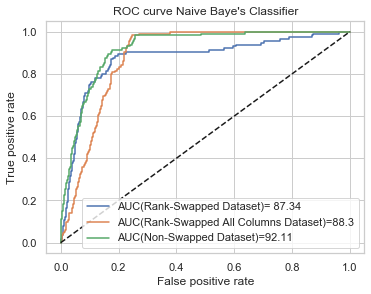

(True neg, False pos, False neg, True Pos) for the three datasets respectively:


((65333, 12269, 21, 93), (55655, 21947, 1, 113), (64830, 12772, 12, 102))

In [64]:
#Defining the classifier
cnb = ComplementNB()

#Fitting the data and making predictions.
y1_pred = cnb.fit(X1_train, y1_train).predict(X1_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped dataset : %d" %(X1_test.shape[0], (y1_test != y1_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y1_test, y1_pred))

#Plotting ROC Curves.
y1_pred_proba = cnb.predict_proba(X1_test)[::,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y1_test, y1_pred_proba)
auc1 = metrics.roc_auc_score(y1_test, y1_pred_proba)
plt.plot(fpr1, tpr1, label="AUC(Rank-Swapped Dataset)= " +str(round(auc1*100,2)))

#Fitting the data and making predictions.
y2_pred = cnb.fit(X2_train, y2_train).predict(X2_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped all columns dataset : %d" %(X2_test.shape[0], (y2_test != y2_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y2_test, y2_pred))

#Plotting ROC Curves.
y2_pred_proba = cnb.predict_proba(X2_test)[::,1]
fpr2, tpr2, thresholds2 = metrics.roc_curve(y2_test, y2_pred_proba)
auc2 = metrics.roc_auc_score(y2_test, y2_pred_proba)
plt.plot(fpr2, tpr2, label="AUC(Rank-Swapped All Columns Dataset)=" +str(round(auc2*100,2)))

#Fitting the data and making predictions.
y3_pred = cnb.fit(X3_train, y3_train).predict(X3_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for non-swapped dataset: %d" %(X3_test.shape[0], (y3_test != y3_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y3_test, y3_pred))

#Plotting ROC Curves.
y3_pred_proba = cnb.predict_proba(X3_test)[::,1]
fpr3, tpr3, thresholds3 = metrics.roc_curve(y3_test, y3_pred_proba)
auc3 = metrics.roc_auc_score(y3_test, y3_pred_proba)
plt.plot(fpr3, tpr3, label="AUC(Non-Swapped Dataset)=" +str(round(auc3*100,2)))

#Labeling the axes approriately.
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("ROC curve Naive Baye's Classifier")
plt.legend(loc=4)
plt.show()

#Printing the confusion matrix details. 
tn1, fp1, fn1, tp1 = confusion_matrix(y1_test,y1_pred).ravel()
tn2, fp2, fn2, tp2 = confusion_matrix(y2_test,y2_pred).ravel()
tn3, fp3, fn3, tp3 = confusion_matrix(y3_test,y3_pred).ravel()
print("(True neg, False pos, False neg, True Pos) for the three datasets respectively:")
(tn1, fp1, fn1, tp1),(tn2, fp2, fn2, tp2),(tn3, fp3, fn3, tp3)

Number of mislabeled points out of a total 77716 points for rank-swapped dataset : 11932
accuracy:  0.8464666220598075
Number of mislabeled points out of a total 77716 points for rank-swapped all columns dataset : 14407
accuracy:  0.8146198980904833
Number of mislabeled points out of a total 77716 points for non-swapped dataset: 12722
accuracy:  0.8363014051160637


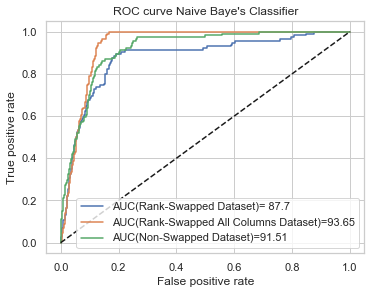

(True neg, False pos, False neg, True Pos) for the three datasets respectively:


((65695, 11907, 25, 89), (63195, 14407, 0, 114), (64895, 12707, 15, 99))

In [53]:
#Defining the classifier
cnb = ComplementNB()

#Fitting the data and making predictions.
y1_pred = cnb.fit(X1_train, y1_train).predict(X1_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped dataset : %d" %(X1_test.shape[0], (y1_test != y1_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y1_test, y1_pred))

#Plotting ROC Curves.
y1_pred_proba = cnb.predict_proba(X1_test)[::,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y1_test, y1_pred_proba)
auc1 = metrics.roc_auc_score(y1_test, y1_pred_proba)
plt.plot(fpr1, tpr1, label="AUC(Rank-Swapped Dataset)= " +str(round(auc1*100,2)))

#Fitting the data and making predictions.
y2_pred = cnb.fit(X2_train, y2_train).predict(X2_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped all columns dataset : %d" %(X2_test.shape[0], (y2_test != y2_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y2_test, y2_pred))

#Plotting ROC Curves.
y2_pred_proba = cnb.predict_proba(X2_test)[::,1]
fpr2, tpr2, thresholds2 = metrics.roc_curve(y2_test, y2_pred_proba)
auc2 = metrics.roc_auc_score(y2_test, y2_pred_proba)
plt.plot(fpr2, tpr2, label="AUC(Rank-Swapped All Columns Dataset)=" +str(round(auc2*100,2)))

#Fitting the data and making predictions.
y3_pred = cnb.fit(X3_train, y3_train).predict(X3_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for non-swapped dataset: %d" %(X3_test.shape[0], (y3_test != y3_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y3_test, y3_pred))

#Plotting ROC Curves.
y3_pred_proba = cnb.predict_proba(X3_test)[::,1]
fpr3, tpr3, thresholds3 = metrics.roc_curve(y3_test, y3_pred_proba)
auc3 = metrics.roc_auc_score(y3_test, y3_pred_proba)
plt.plot(fpr3, tpr3, label="AUC(Non-Swapped Dataset)=" +str(round(auc3*100,2)))

#Labeling the axes approriately.
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("ROC curve Naive Baye's Classifier")
plt.legend(loc=4)
plt.show()

#Printing the confusion matrix details. 
tn1, fp1, fn1, tp1 = confusion_matrix(y1_test,y1_pred).ravel()
tn2, fp2, fn2, tp2 = confusion_matrix(y2_test,y2_pred).ravel()
tn3, fp3, fn3, tp3 = confusion_matrix(y3_test,y3_pred).ravel()
print("(True neg, False pos, False neg, True Pos) for the three datasets respectively:")
(tn1, fp1, fn1, tp1),(tn2, fp2, fn2, tp2),(tn3, fp3, fn3, tp3)

Number of mislabeled points out of a total 78222 points for rank-swapped dataset : 12561
accuracy:  0.8394185778936872
Number of mislabeled points out of a total 78222 points for rank-swapped all columns dataset : 14192
accuracy:  0.8185676663854159
Number of mislabeled points out of a total 78222 points for non-swapped dataset: 12763
accuracy:  0.8368361841937051


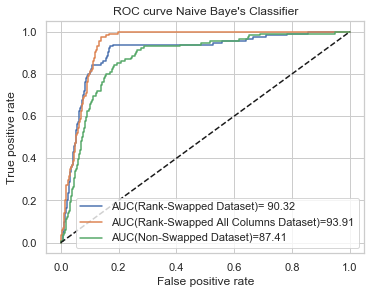

(True neg, False pos, False neg, True Pos) for the three datasets respectively:


((65561, 12547, 14, 100), (63917, 14191, 1, 113), (65368, 12740, 23, 91))

In [29]:
#Defining the classifier
cnb = ComplementNB()

#Fitting the data and making predictions.
y1_pred = cnb.fit(X1_train, y1_train).predict(X1_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped dataset : %d" %(X1_test.shape[0], (y1_test != y1_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y1_test, y1_pred))

#Plotting ROC Curves.
y1_pred_proba = cnb.predict_proba(X1_test)[::,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y1_test, y1_pred_proba)
auc1 = metrics.roc_auc_score(y1_test, y1_pred_proba)
plt.plot(fpr1, tpr1, label="AUC(Rank-Swapped Dataset)= " +str(round(auc1*100,2)))

#Fitting the data and making predictions.
y2_pred = cnb.fit(X2_train, y2_train).predict(X2_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped all columns dataset : %d" %(X2_test.shape[0], (y2_test != y2_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y2_test, y2_pred))

#Plotting ROC Curves.
y2_pred_proba = cnb.predict_proba(X2_test)[::,1]
fpr2, tpr2, thresholds2 = metrics.roc_curve(y2_test, y2_pred_proba)
auc2 = metrics.roc_auc_score(y2_test, y2_pred_proba)
plt.plot(fpr2, tpr2, label="AUC(Rank-Swapped All Columns Dataset)=" +str(round(auc2*100,2)))

#Fitting the data and making predictions.
y3_pred = cnb.fit(X3_train, y3_train).predict(X3_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for non-swapped dataset: %d" %(X3_test.shape[0], (y3_test != y3_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y3_test, y3_pred))

#Plotting ROC Curves.
y3_pred_proba = cnb.predict_proba(X3_test)[::,1]
fpr3, tpr3, thresholds3 = metrics.roc_curve(y3_test, y3_pred_proba)
auc3 = metrics.roc_auc_score(y3_test, y3_pred_proba)
plt.plot(fpr3, tpr3, label="AUC(Non-Swapped Dataset)=" +str(round(auc3*100,2)))

#Labeling the axes approriately.
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("ROC curve Naive Baye's Classifier")
plt.legend(loc=4)
plt.show()

#Printing the confusion matrix details. 
tn1, fp1, fn1, tp1 = confusion_matrix(y1_test,y1_pred).ravel()
tn2, fp2, fn2, tp2 = confusion_matrix(y2_test,y2_pred).ravel()
tn3, fp3, fn3, tp3 = confusion_matrix(y3_test,y3_pred).ravel()
print("(True neg, False pos, False neg, True Pos) for the three datasets respectively:")
(tn1, fp1, fn1, tp1),(tn2, fp2, fn2, tp2),(tn3, fp3, fn3, tp3)

### Logistic Regression

Number of mislabeled points out of a total 77716 points for rank-swapped dataset : 6887
accuracy:  0.9113824695043492
Number of mislabeled points out of a total 77716 points for rank-swapped all columns dataset : 6664
accuracy:  0.9142518915023933
Number of mislabeled points out of a total 77716 points for non-swapped dataset: 5120
accuracy:  0.9341191003139636


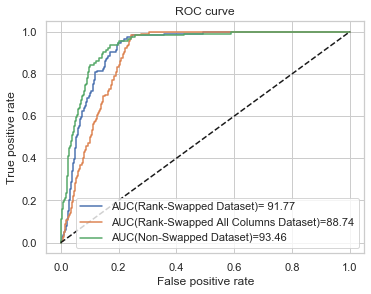

(True neg, False pos, False neg, True Pos) for the three datasets respectively:


((70753, 6849, 38, 76), (71002, 6600, 64, 50), (72522, 5080, 40, 74))

In [65]:
#Defining the classifier
clf =LogisticRegression(max_iter=1000)

#Fitting the data and making predictions.
y1_pred = clf.fit(X1_train, y1_train).predict(X1_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped dataset : %d" %(X1_test.shape[0], (y1_test != y1_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y1_test, y1_pred))

#Plotting ROC Curves.
y1_pred_proba = clf.predict_proba(X1_test)[::,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y1_test, y1_pred_proba)
auc1 = metrics.roc_auc_score(y1_test, y1_pred_proba)
plt.plot(fpr1, tpr1, label="AUC(Rank-Swapped Dataset)= " +str(round(auc1*100,2)))

#Fitting the data and making predictions.
y2_pred = clf.fit(X2_train, y2_train).predict(X2_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped all columns dataset : %d" %(X2_test.shape[0], (y2_test != y2_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y2_test, y2_pred))

#Plotting ROC Curves.
y2_pred_proba = clf.predict_proba(X2_test)[::,1]
fpr2, tpr2, thresholds2 = metrics.roc_curve(y2_test, y2_pred_proba)
auc2 = metrics.roc_auc_score(y2_test, y2_pred_proba)
plt.plot(fpr2, tpr2, label="AUC(Rank-Swapped All Columns Dataset)=" +str(round(auc2*100,2)))

#Fitting the data and making predictions.
y3_pred = clf.fit(X3_train, y3_train).predict(X3_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for non-swapped dataset: %d" %(X3_test.shape[0], (y3_test != y3_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y3_test, y3_pred))

#Plotting ROC Curves.
y3_pred_proba = clf.predict_proba(X3_test)[::,1]
fpr3, tpr3, thresholds3 = metrics.roc_curve(y3_test, y3_pred_proba)
auc3 = metrics.roc_auc_score(y3_test, y3_pred_proba)
plt.plot(fpr3, tpr3, label="AUC(Non-Swapped Dataset)=" +str(round(auc3*100,2)))

#Labeling the axes approriately.
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc=4)
plt.show()

#Printing the confusion matrix details. 
tn1, fp1, fn1, tp1 = confusion_matrix(y1_test,y1_pred).ravel()
tn2, fp2, fn2, tp2 = confusion_matrix(y2_test,y2_pred).ravel()
tn3, fp3, fn3, tp3 = confusion_matrix(y3_test,y3_pred).ravel()
print("(True neg, False pos, False neg, True Pos) for the three datasets respectively:")
(tn1, fp1, fn1, tp1),(tn2, fp2, fn2, tp2),(tn3, fp3, fn3, tp3)

Number of mislabeled points out of a total 77716 points for rank-swapped dataset : 6287
accuracy:  0.9191028874363065
Number of mislabeled points out of a total 77716 points for rank-swapped all columns dataset : 6989
accuracy:  0.9100699984559164
Number of mislabeled points out of a total 77716 points for non-swapped dataset: 4351
accuracy:  0.944014102630089


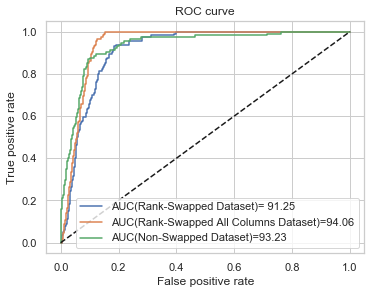

(True neg, False pos, False neg, True Pos) for the three datasets respectively:


((71361, 6241, 46, 68), (70638, 6964, 25, 89), (73297, 4305, 46, 68))

In [54]:
#Defining the classifier
clf =LogisticRegression(max_iter=1000)

#Fitting the data and making predictions.
y1_pred = clf.fit(X1_train, y1_train).predict(X1_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped dataset : %d" %(X1_test.shape[0], (y1_test != y1_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y1_test, y1_pred))

#Plotting ROC Curves.
y1_pred_proba = clf.predict_proba(X1_test)[::,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y1_test, y1_pred_proba)
auc1 = metrics.roc_auc_score(y1_test, y1_pred_proba)
plt.plot(fpr1, tpr1, label="AUC(Rank-Swapped Dataset)= " +str(round(auc1*100,2)))

#Fitting the data and making predictions.
y2_pred = clf.fit(X2_train, y2_train).predict(X2_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped all columns dataset : %d" %(X2_test.shape[0], (y2_test != y2_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y2_test, y2_pred))

#Plotting ROC Curves.
y2_pred_proba = clf.predict_proba(X2_test)[::,1]
fpr2, tpr2, thresholds2 = metrics.roc_curve(y2_test, y2_pred_proba)
auc2 = metrics.roc_auc_score(y2_test, y2_pred_proba)
plt.plot(fpr2, tpr2, label="AUC(Rank-Swapped All Columns Dataset)=" +str(round(auc2*100,2)))

#Fitting the data and making predictions.
y3_pred = clf.fit(X3_train, y3_train).predict(X3_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for non-swapped dataset: %d" %(X3_test.shape[0], (y3_test != y3_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y3_test, y3_pred))

#Plotting ROC Curves.
y3_pred_proba = clf.predict_proba(X3_test)[::,1]
fpr3, tpr3, thresholds3 = metrics.roc_curve(y3_test, y3_pred_proba)
auc3 = metrics.roc_auc_score(y3_test, y3_pred_proba)
plt.plot(fpr3, tpr3, label="AUC(Non-Swapped Dataset)=" +str(round(auc3*100,2)))

#Labeling the axes approriately.
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc=4)
plt.show()

#Printing the confusion matrix details. 
tn1, fp1, fn1, tp1 = confusion_matrix(y1_test,y1_pred).ravel()
tn2, fp2, fn2, tp2 = confusion_matrix(y2_test,y2_pred).ravel()
tn3, fp3, fn3, tp3 = confusion_matrix(y3_test,y3_pred).ravel()
print("(True neg, False pos, False neg, True Pos) for the three datasets respectively:")
(tn1, fp1, fn1, tp1),(tn2, fp2, fn2, tp2),(tn3, fp3, fn3, tp3)

Number of mislabeled points out of a total 78222 points for rank-swapped dataset : 5353
accuracy:  0.9315665669504742
Number of mislabeled points out of a total 78222 points for rank-swapped all columns dataset : 6327
accuracy:  0.9191148270307586
Number of mislabeled points out of a total 78222 points for non-swapped dataset: 5350
accuracy:  0.9316049193321572


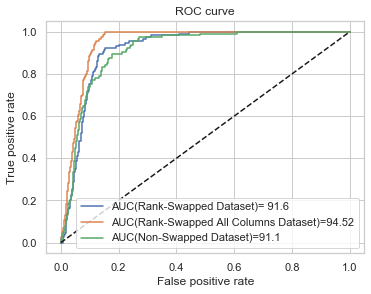

(True neg, False pos, False neg, True Pos) for the three datasets respectively:


((72814, 5294, 59, 55), (71807, 6301, 26, 88), (72805, 5303, 47, 67))

In [27]:
#Defining the classifier
clf =LogisticRegression(max_iter=1000)

#Fitting the data and making predictions.
y1_pred = clf.fit(X1_train, y1_train).predict(X1_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped dataset : %d" %(X1_test.shape[0], (y1_test != y1_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y1_test, y1_pred))

#Plotting ROC Curves.
y1_pred_proba = clf.predict_proba(X1_test)[::,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y1_test, y1_pred_proba)
auc1 = metrics.roc_auc_score(y1_test, y1_pred_proba)
plt.plot(fpr1, tpr1, label="AUC(Rank-Swapped Dataset)= " +str(round(auc1*100,2)))

#Fitting the data and making predictions.
y2_pred = clf.fit(X2_train, y2_train).predict(X2_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped all columns dataset : %d" %(X2_test.shape[0], (y2_test != y2_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y2_test, y2_pred))

#Plotting ROC Curves.
y2_pred_proba = clf.predict_proba(X2_test)[::,1]
fpr2, tpr2, thresholds2 = metrics.roc_curve(y2_test, y2_pred_proba)
auc2 = metrics.roc_auc_score(y2_test, y2_pred_proba)
plt.plot(fpr2, tpr2, label="AUC(Rank-Swapped All Columns Dataset)=" +str(round(auc2*100,2)))

#Fitting the data and making predictions.
y3_pred = clf.fit(X3_train, y3_train).predict(X3_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for non-swapped dataset: %d" %(X3_test.shape[0], (y3_test != y3_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y3_test, y3_pred))

#Plotting ROC Curves.
y3_pred_proba = clf.predict_proba(X3_test)[::,1]
fpr3, tpr3, thresholds3 = metrics.roc_curve(y3_test, y3_pred_proba)
auc3 = metrics.roc_auc_score(y3_test, y3_pred_proba)
plt.plot(fpr3, tpr3, label="AUC(Non-Swapped Dataset)=" +str(round(auc3*100,2)))

#Labeling the axes approriately.
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc=4)
plt.show()

#Printing the confusion matrix details. 
tn1, fp1, fn1, tp1 = confusion_matrix(y1_test,y1_pred).ravel()
tn2, fp2, fn2, tp2 = confusion_matrix(y2_test,y2_pred).ravel()
tn3, fp3, fn3, tp3 = confusion_matrix(y3_test,y3_pred).ravel()
print("(True neg, False pos, False neg, True Pos) for the three datasets respectively:")
(tn1, fp1, fn1, tp1),(tn2, fp2, fn2, tp2),(tn3, fp3, fn3, tp3)

### Gradient Boosting Classifier. 

Number of mislabeled points out of a total 77716 points for rank-swapped dataset : 4890
accuracy:  0.9370785938545473
Number of mislabeled points out of a total 77716 points for rank-swapped all columns dataset : 457
accuracy:  0.9941196150084924
Number of mislabeled points out of a total 77716 points for non-swapped dataset: 2737
accuracy:  0.9647820268670544


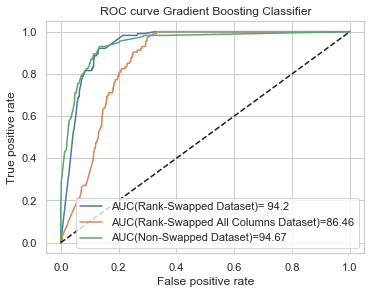

(True neg, False pos, False neg, True Pos) for the three datasets respectively:


((72747, 4855, 35, 79), (77258, 344, 113, 1), (74912, 2690, 47, 67))

In [66]:
#Defining the classifier
clf = GradientBoostingClassifier(n_estimators=10)

#Fitting the data and making predictions.
y1_pred = clf.fit(X1_train, y1_train).predict(X1_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped dataset : %d" %(X1_test.shape[0], (y1_test != y1_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y1_test, y1_pred))

#Plotting ROC Curves.
y1_pred_proba = clf.predict_proba(X1_test)[::,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y1_test, y1_pred_proba)
auc1 = metrics.roc_auc_score(y1_test, y1_pred_proba)
plt.plot(fpr1, tpr1, label="AUC(Rank-Swapped Dataset)= " +str(round(auc1*100,2)))

#Fitting the data and making predictions.
y2_pred = clf.fit(X2_train, y2_train).predict(X2_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped all columns dataset : %d" %(X2_test.shape[0], (y2_test != y2_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y2_test, y2_pred))

#Plotting ROC Curves.
y2_pred_proba = clf.predict_proba(X2_test)[::,1]
fpr2, tpr2, thresholds2 = metrics.roc_curve(y2_test, y2_pred_proba)
auc2 = metrics.roc_auc_score(y2_test, y2_pred_proba)
plt.plot(fpr2, tpr2, label="AUC(Rank-Swapped All Columns Dataset)=" +str(round(auc2*100,2)))

#Fitting the data and making predictions.
y3_pred = clf.fit(X3_train, y3_train).predict(X3_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for non-swapped dataset: %d" %(X3_test.shape[0], (y3_test != y3_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y3_test, y3_pred))

#Plotting ROC Curves.
y3_pred_proba = clf.predict_proba(X3_test)[::,1]
fpr3, tpr3, thresholds3 = metrics.roc_curve(y3_test, y3_pred_proba)
auc3 = metrics.roc_auc_score(y3_test, y3_pred_proba)
plt.plot(fpr3, tpr3, label="AUC(Non-Swapped Dataset)=" +str(round(auc3*100,2)))

#Labeling the axes approriately.
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve Gradient Boosting Classifier')
plt.legend(loc=4)
plt.show()

#Printing the confusion matrix details. 
tn1, fp1, fn1, tp1 = confusion_matrix(y1_test,y1_pred).ravel()
tn2, fp2, fn2, tp2 = confusion_matrix(y2_test,y2_pred).ravel()
tn3, fp3, fn3, tp3 = confusion_matrix(y3_test,y3_pred).ravel()
print("(True neg, False pos, False neg, True Pos) for the three datasets respectively:")
(tn1, fp1, fn1, tp1),(tn2, fp2, fn2, tp2),(tn3, fp3, fn3, tp3)

Number of mislabeled points out of a total 77716 points for rank-swapped dataset : 4661
accuracy:  0.940025220031911
Number of mislabeled points out of a total 77716 points for rank-swapped all columns dataset : 4093
accuracy:  0.9473338823408307
Number of mislabeled points out of a total 77716 points for non-swapped dataset: 2709
accuracy:  0.9651423130372124


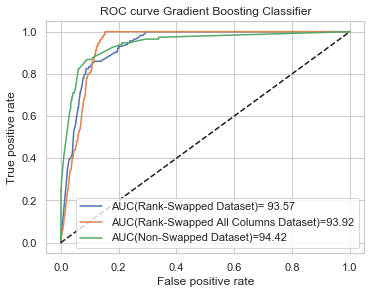

(True neg, False pos, False neg, True Pos) for the three datasets respectively:


((72983, 4619, 42, 72), (73571, 4031, 62, 52), (74934, 2668, 41, 73))

In [55]:
#Defining the classifier
clf = GradientBoostingClassifier(n_estimators=10)

#Fitting the data and making predictions.
y1_pred = clf.fit(X1_train, y1_train).predict(X1_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped dataset : %d" %(X1_test.shape[0], (y1_test != y1_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y1_test, y1_pred))

#Plotting ROC Curves.
y1_pred_proba = clf.predict_proba(X1_test)[::,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y1_test, y1_pred_proba)
auc1 = metrics.roc_auc_score(y1_test, y1_pred_proba)
plt.plot(fpr1, tpr1, label="AUC(Rank-Swapped Dataset)= " +str(round(auc1*100,2)))

#Fitting the data and making predictions.
y2_pred = clf.fit(X2_train, y2_train).predict(X2_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped all columns dataset : %d" %(X2_test.shape[0], (y2_test != y2_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y2_test, y2_pred))

#Plotting ROC Curves.
y2_pred_proba = clf.predict_proba(X2_test)[::,1]
fpr2, tpr2, thresholds2 = metrics.roc_curve(y2_test, y2_pred_proba)
auc2 = metrics.roc_auc_score(y2_test, y2_pred_proba)
plt.plot(fpr2, tpr2, label="AUC(Rank-Swapped All Columns Dataset)=" +str(round(auc2*100,2)))

#Fitting the data and making predictions.
y3_pred = clf.fit(X3_train, y3_train).predict(X3_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for non-swapped dataset: %d" %(X3_test.shape[0], (y3_test != y3_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y3_test, y3_pred))

#Plotting ROC Curves.
y3_pred_proba = clf.predict_proba(X3_test)[::,1]
fpr3, tpr3, thresholds3 = metrics.roc_curve(y3_test, y3_pred_proba)
auc3 = metrics.roc_auc_score(y3_test, y3_pred_proba)
plt.plot(fpr3, tpr3, label="AUC(Non-Swapped Dataset)=" +str(round(auc3*100,2)))

#Labeling the axes approriately.
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve Gradient Boosting Classifier')
plt.legend(loc=4)
plt.show()

#Printing the confusion matrix details. 
tn1, fp1, fn1, tp1 = confusion_matrix(y1_test,y1_pred).ravel()
tn2, fp2, fn2, tp2 = confusion_matrix(y2_test,y2_pred).ravel()
tn3, fp3, fn3, tp3 = confusion_matrix(y3_test,y3_pred).ravel()
print("(True neg, False pos, False neg, True Pos) for the three datasets respectively:")
(tn1, fp1, fn1, tp1),(tn2, fp2, fn2, tp2),(tn3, fp3, fn3, tp3)

Number of mislabeled points out of a total 78222 points for rank-swapped dataset : 3734
accuracy:  0.952264068932014
Number of mislabeled points out of a total 78222 points for rank-swapped all columns dataset : 4392
accuracy:  0.9438521132162307
Number of mislabeled points out of a total 78222 points for non-swapped dataset: 2869
accuracy:  0.9633223389839176


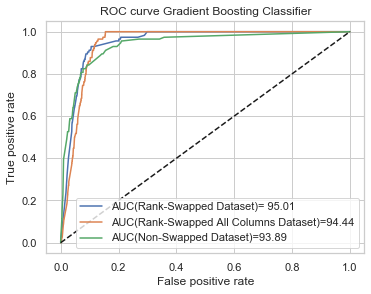

(True neg, False pos, False neg, True Pos) for the three datasets respectively:


((74415, 3693, 41, 73), (73767, 4341, 51, 63), (75286, 2822, 47, 67))

In [28]:
#Defining the classifier
clf = GradientBoostingClassifier(n_estimators=10)

#Fitting the data and making predictions.
y1_pred = clf.fit(X1_train, y1_train).predict(X1_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped dataset : %d" %(X1_test.shape[0], (y1_test != y1_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y1_test, y1_pred))

#Plotting ROC Curves.
y1_pred_proba = clf.predict_proba(X1_test)[::,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y1_test, y1_pred_proba)
auc1 = metrics.roc_auc_score(y1_test, y1_pred_proba)
plt.plot(fpr1, tpr1, label="AUC(Rank-Swapped Dataset)= " +str(round(auc1*100,2)))

#Fitting the data and making predictions.
y2_pred = clf.fit(X2_train, y2_train).predict(X2_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped all columns dataset : %d" %(X2_test.shape[0], (y2_test != y2_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y2_test, y2_pred))

#Plotting ROC Curves.
y2_pred_proba = clf.predict_proba(X2_test)[::,1]
fpr2, tpr2, thresholds2 = metrics.roc_curve(y2_test, y2_pred_proba)
auc2 = metrics.roc_auc_score(y2_test, y2_pred_proba)
plt.plot(fpr2, tpr2, label="AUC(Rank-Swapped All Columns Dataset)=" +str(round(auc2*100,2)))

#Fitting the data and making predictions.
y3_pred = clf.fit(X3_train, y3_train).predict(X3_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for non-swapped dataset: %d" %(X3_test.shape[0], (y3_test != y3_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y3_test, y3_pred))

#Plotting ROC Curves.
y3_pred_proba = clf.predict_proba(X3_test)[::,1]
fpr3, tpr3, thresholds3 = metrics.roc_curve(y3_test, y3_pred_proba)
auc3 = metrics.roc_auc_score(y3_test, y3_pred_proba)
plt.plot(fpr3, tpr3, label="AUC(Non-Swapped Dataset)=" +str(round(auc3*100,2)))

#Labeling the axes approriately.
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve Gradient Boosting Classifier')
plt.legend(loc=4)
plt.show()

#Printing the confusion matrix details. 
tn1, fp1, fn1, tp1 = confusion_matrix(y1_test,y1_pred).ravel()
tn2, fp2, fn2, tp2 = confusion_matrix(y2_test,y2_pred).ravel()
tn3, fp3, fn3, tp3 = confusion_matrix(y3_test,y3_pred).ravel()
print("(True neg, False pos, False neg, True Pos) for the three datasets respectively:")
(tn1, fp1, fn1, tp1),(tn2, fp2, fn2, tp2),(tn3, fp3, fn3, tp3)

### 3b. Performance Analysis and Explaination for Differences within the Classifiers.

#### Naive Baye's Classifier-

Here I've used the complement naive baye's classifier which as mentioned in the sklearn documentation treats every variable as having a multinomial distribution which is in agreement with the kind of variables we have in our dataset as they are mostly categorical in nature. Additionally, this classifier is also well suited for class imbalances as well. I would like to mention that this model correctly classified almost all positive cases of fraud(113/114) in the test set for the (all-columns) rank-swapped dataset. However this comes at the cost of too many false positives(13375) as well which is expected as this classifier has a high bias in general due to it's strong("naive") probabilistic assumptions about features being independent. 
Furthermore, for this classifier, we see that the area under the ROC curve is highest for the dataset with all the columns being rank-swapped(93.64%). These results were quite surprising initially but I believe that this result can be explained by the fact that re-ordering all columns instead of just the few ordinal columns makes the entire dataset a bit more homogenous as compared to performing rank-swapping for just the ordinal ones, making it less noisy and perhaps making it easier for the model to learn as well. In terms of accuracy, we actually see that rank-swapped data with just the ordinal columns being swapped does best but we know that accuracy is a misleading metric when it comes to such an imbalanced dataset. Lastly, we see that the overall performance of this classifier as compared to the rest is quite poor.  

#### Logistic Classifier-

Stepping into a stronger classifier, the logistic classifier maximizes the data likelihood(assuming data points are I.I.D) to choose the best set of parameters for the model using the gradient descent method. And so I've set max_iter to be 1000 for it to converge to the correct parameter settings. This model has been known to work well for binary classification problems in practice as it assumes the labels to follow a bernoulli distribution(binary labels i.e Fraud or Not) and doesn't make strict probabilistic assumptions as mentioned previously(has less bias basically). Indeed, we see that it already does considerably better than the naive baye's classifier which is expected. Here we see that the ROC curve is similarly best for rank-swapping the entire dataset as well(94.52%). We also observe that for the (all-columns) rank-swapped dataset, it is able to correctly classify 88 out of 114 cases of fraud but with 6301 false positives which is much lesser than the previous classifier(less than half!). In terms of accuracy, we see that it's better than Naive Baye's ofcourse and we also see that the dataset which contains no rankswapping actually attains the best accuracy in this case which is closely followed by the dataset on which we only rank-swap ordinal columns.  

#### Gradient Boosting Classifier-
Last but definitely not the least, I've used the Gradient Boosting Classifier which is an ensemble model meaning that it comprises of multiple weak learners to finally output a good prediction. This type of classifier relies on decision trees which are incrementally added over time and whose parameters are adjusted based on similar gradient descent optimization techniques which aim to minimize the error or overall loss of the model. This model actually outperforms both the previous classifiers in terms of accuracy and has the overall highest area under the ROC curve. Furthermore we see that, it is able to correctly classify 73 out of 114 cases of fraud in the test set and does so with the least number of false positives(3693) on the ranked-swapped data. Unlike previous classifiers, we see that the highest AUC is not for the all-columns ranked swapped dataset but the dataset where we only rank-swap ordinal columns(95.01). I do not yet have an explanation for this to be frank. But I suspect that this model is much more flexible(higher variance and lesser bias) than the previous models and so is able to get distubred more easily by all-columns being rank swapped thereby slightly hurting performance as compared to the other models. 


*Kindly note that the values mentioned here will change slightly based on running the code again*

### 3c. Is it advisable to protect people’s privacy using rank-swapping? Why (not)?

Based on my results, I would say that performing rank swapping doesn't seem to hurt performance at all. Infact, I see that it sometimes results in a higher area under the ROC curve. Hence, based on my results I believe rank swapping is a good overall method for protecting people's privacy as it still allows researchers to use the data effectively without comprising on ethical concerns of privacy by disordering and thereby masking particularly sensitive personal information for a given row. In addition it's relatively easy to implement and can be used independently on different columns of the dataset. Furthermore, the fact that the user can also adjust the percentage of total rows for which two ranked values in a column can be swapped makes it possible to better suit the needs of a wide variety of datasets. Lastly, we also see that with the percentage set to 10% as I have, even sub sampling the data randomly didn't destroy the multi-variate statistics of the sampled data and the same also goes for the number of columns being rank-swapped. (*I'm basing this purely on my results obtained from the different classifiers*). 